In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x

Domain Adaptation/Generalisierung ohne distance_loss (mit/ohne Augmentation)


In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.datasets import mnist
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import h5py
from skimage.transform import resize
from skimage.color import gray2rgb

batch_size = 50
num_classes = 10
epochs = 10
num_train_samples = 1000
val_size = 5000

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def load_svhn_data(path, val_size, num_classes):
    with h5py.File(path+'/SVHN_train.hdf5', 'r') as f:
        shape = f["X"].shape
        x_train = f["X"][:shape[0]-val_size]
        y_train = f["Y"][:shape[0]-val_size].flatten()
        x_val = f["X"][shape[0]-val_size:]
        y_val = f["Y"][shape[0] - val_size:].flatten()

    with h5py.File(path+'/SVHN_test.hdf5', 'r') as f:
        x_test = f["X"][:]
        y_test = f["Y"][:].flatten()

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def reshapeImages(images):
    images_redone = []
    for image in images:
        image = resize(image,(32,32))
        image = gray2rgb(image)
        images_redone.append(image)
    images = np.asarray(images_redone)
    images = images.reshape(images.shape[0], 32, 32, 3)
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
# the data, split between train and test sets
# The full `train` split and the full `test` split as two distinct datasets.
(x_train_svhn, y_train_svhn), (x_val_svhn, y_val_svhn), (x_test_svhn, y_test_svhn) = load_svhn_data('drive/My Drive/Data/svhn', val_size, num_classes)
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
print(y_train_mnist.shape)

(60000,)


In [ ]:
x_val_mnist = reshapeImages(x_train_mnist)[x_train_mnist.shape[0]-5000:]
x_train_mnist = reshapeImages(x_train_mnist)[:200]
x_test_mnist = reshapeImages(x_test_mnist)

# convert class vectors to binary class matrices
y_val_mnist = keras.utils.to_categorical(y_train_mnist, num_classes)[y_train_mnist.shape[0]-5000:]
y_train_mnist = keras.utils.to_categorical(y_train_mnist, num_classes)[:200]
y_test_mnist = keras.utils.to_categorical(y_test_mnist, num_classes)

60000 samples
60000 samples
10000 samples


In [ ]:
input1 = keras.layers.Input(shape=(32,32,3))
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(input1)
conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu')(conv1)
maxpool1 = keras.layers.MaxPooling2D((2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.1)(maxpool1)
conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(dropout1)
conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu')(conv3)
maxpool2 = keras.layers.MaxPooling2D((2, 2))(conv4)
flatten = keras.layers.Flatten()(maxpool2)
dense2 = keras.layers.Dense(512, activation='relu')(flatten)
output = keras.layers.Dense(num_classes, activation='softmax')(dense2)

model = keras.Model(inputs=input1, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(x=x_train_svhn, 
          y=y_train_svhn,
          batch_size=batch_size, 
          epochs = epochs,
          verbose=1,
          validation_data=(x_val_svhn,y_val_svhn)
          )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        3692

In [ ]:
score = model.evaluate(x_test_mnist, y_test_mnist, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.821498394012451
Test accuracy: 0.11349999904632568


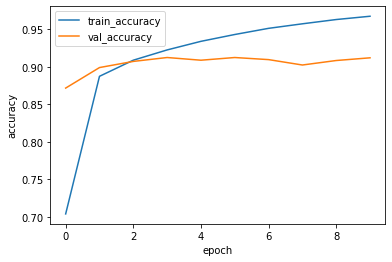

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
plt.show()